# Analyzing FBGRX with SARIMA Modeling and Risk Metrics: Alpha and Beta Estimation

In this notebook, I aim to understand the nature of the Fidelity Blue Chip Growth Fund (FBGRX) through two complementary approaches: time series analysis and benchmark comparison. First, I explore the fund’s potential future trends by walking through the steps of selecting appropriate parameters for a SARIMA model. While I do not run the model due to computational constraints, this process helps to deepen my understanding of how seasonal and trend components affect time series forecasting. Afterward, I calculate the alpha and beta of FBGRX relative to the Russell 1000 Index using regression analysis. This allows me to assess the fund’s excess returns and its sensitivity to market movements. By combining these approaches, I gain a more holistic view of the fund’s behavior, focusing both on its relationship with the broader market and its potential future performance.

By thoroughly analyzing the data and considering seasonal patterns, trends, and lag relationships, this manual approach highlights the role of each parameter in capturing the behavior of the time series. This hands-on analysis not only deepened my understanding of SARIMA's structure but also enhanced my ability to make more informed decisions when constructing similar models in the future.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Funds like FBGRX (Fidelity Blue Chip Growth Fund) are actively managed mutual funds that aim to deliver capital appreciation by investing in large, well-established companies, often referred to as "blue-chip" stocks. These companies typically have a strong market presence, consistent earnings growth, and a history of financial stability. FBGRX focuses on growth-oriented investments, targeting firms with high potential for revenue and profit expansion, often in sectors like technology, healthcare, or consumer discretionary. Managed by professional portfolio managers, the fund's goal is to outperform benchmark indices, such as the Russell 1000 Growth Index, over the long term. By diversifying across various high-quality growth stocks, FBGRX seeks to mitigate risks while taking advantage of market opportunities, making it an attractive option for investors with a long-term perspective who are willing to tolerate moderate risk in pursuit of higher returns.

In [2]:
ticker = 'FBGRX'
data = yf.download(ticker, start='2010-01-01', end='2024-11-18', interval='1d')

#reset index and set the 'Date' as the index
data.reset_index(inplace=True)
data.set_index('Date', inplace=True)

#select the 'Close' column and ensure no missing values
data = data['Close'].dropna()

#remove timezone information (if any)
data.index = data.index.tz_localize(None)

#set frequency to daily ('D') and reindex (forward fill missing data if necessary)
data = data.asfreq('D').fillna(method='ffill')

#confirm the frequency is set correctly
print(data.index.freq)
print(data.head())

[*********************100%***********************]  1 of 1 completed

<Day>
Ticker          FBGRX
Date                 
2010-01-04  38.590000
2010-01-05  38.820000
2010-01-06  38.790001
2010-01-07  38.869999
2010-01-08  39.049999



<ipython-input-2-4f40d18d6967>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.asfreq('D').fillna(method='ffill')


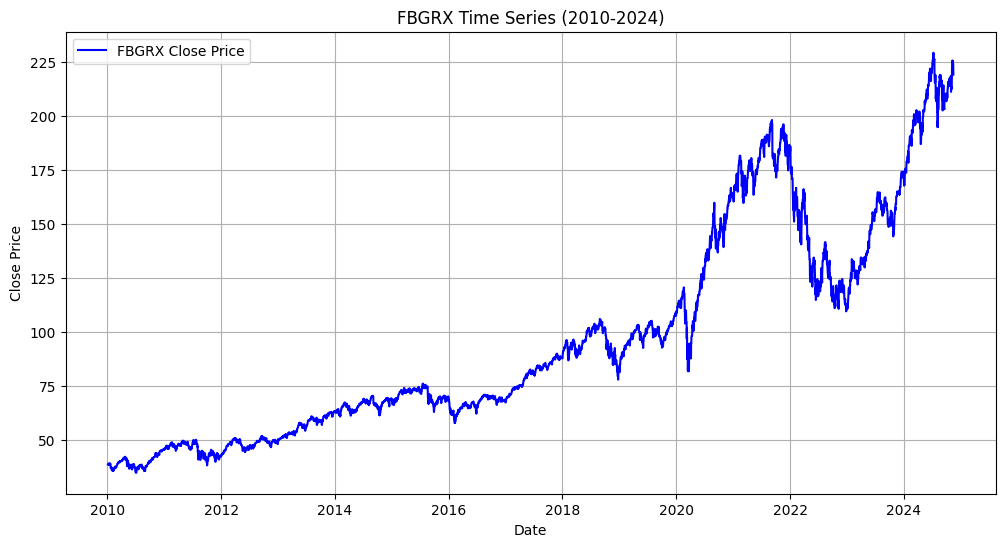

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='FBGRX Close Price', color='blue')
plt.title('FBGRX Time Series (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

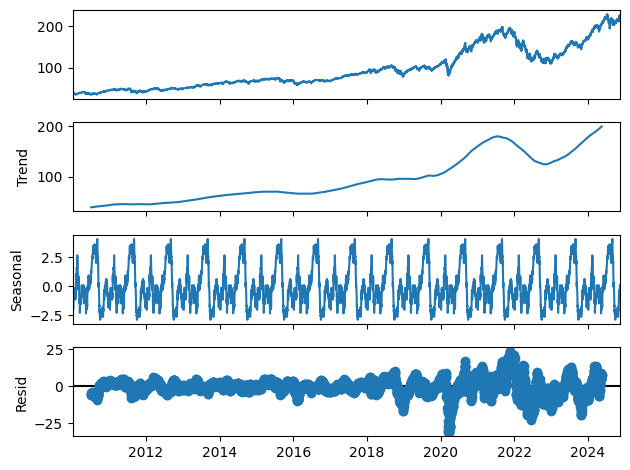

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data, model='additive', period=365)
result.plot()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

#initialize variables
diff_count = 0
max_diffs = 5  #maximum number of differencing attempts to prevent infinite loops
data_diff = data.copy()

#perform ADF test with a loop for differencing
for i in range(max_diffs):
    result = adfuller(data_diff)
    print(f'Attempt {i + 1}: ADF Statistic = {result[0]}, p-value = {result[1]}')

    #check stationarity
    if result[1] <= 0.05:
        print(f"The data is stationary after {diff_count} differencing(s).")
        break

    #if not stationary, difference the data again
    data_diff = data_diff.diff().dropna()
    diff_count += 1
else:
    print(f"The data is still not stationary after {max_diffs} differencing(s).")

#output the final differenced data and the number of differencing
print(f"Number of differencing(s) performed: {diff_count}")

Attempt 1: ADF Statistic = 0.5026700187369838, p-value = 0.9849540238399129
Attempt 2: ADF Statistic = -14.029457590363085, p-value = 3.4556080261914977e-26
The data is stationary after 1 differencing(s).
Number of differencing(s) performed: 1


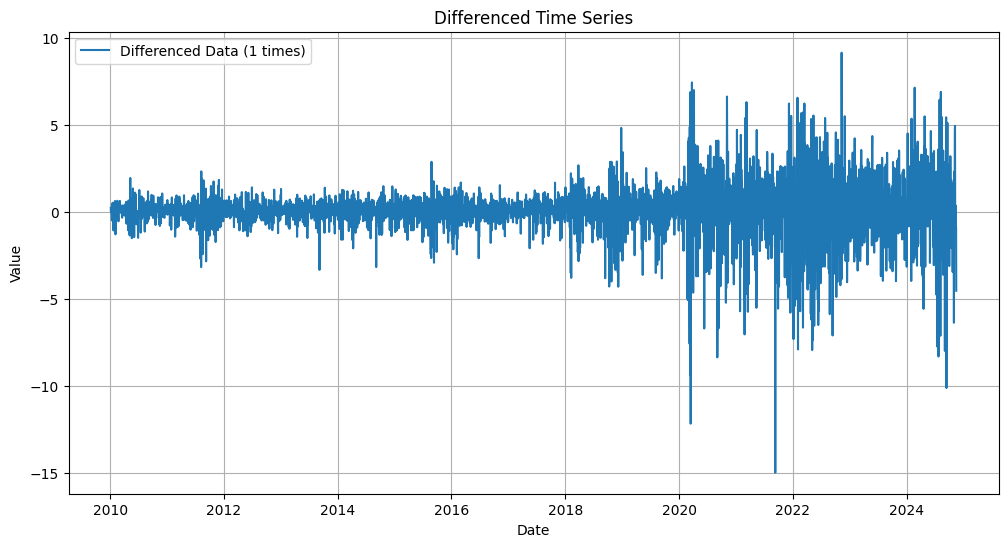

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label=f'Differenced Data ({diff_count} times)')
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

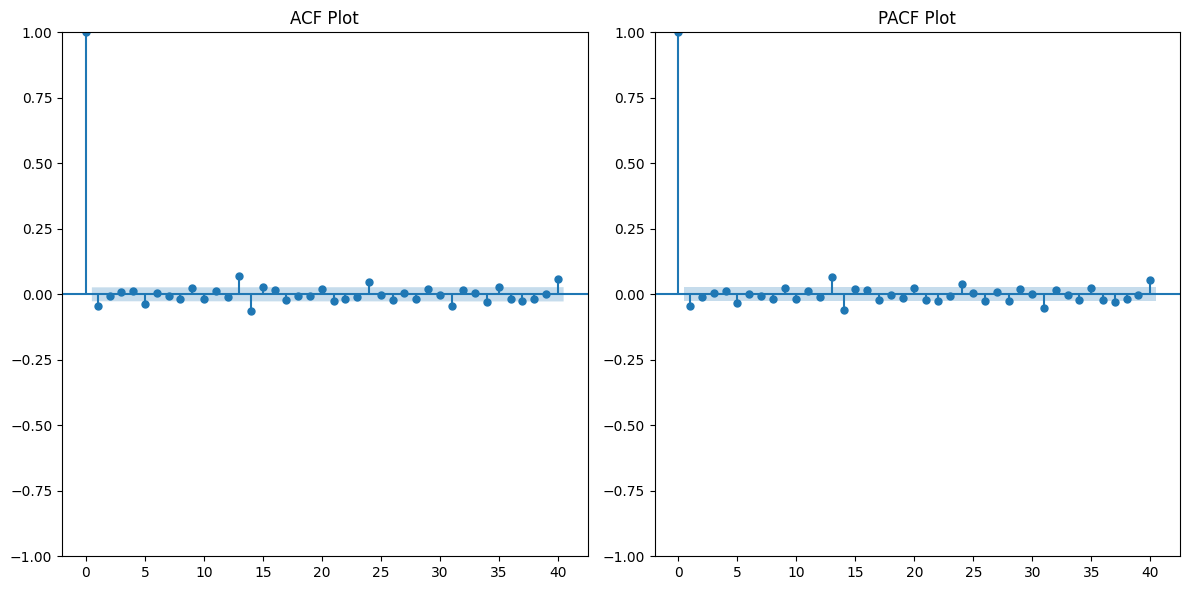

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#plot ACF and PACF
plt.figure(figsize=(12, 6))

#ACF Plot
plt.subplot(1, 2, 1)
plot_acf(data_diff, lags=40, ax=plt.gca())
plt.title('ACF Plot')

#PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(data_diff, lags=40, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

The ACF (Autocorrelation Function) plot shows how strongly the current value of the data is related to past values, including the combined effects of all earlier time points. In contrast, the PACF (Partial Autocorrelation Function) plot shows the direct relationship between the current value and a specific time point in the past, ignoring the influence of other past values. The ACF helps identify overall patterns, while the PACF focuses on which specific time points have a direct effect.

More on ACF: To create an ACF plot, we measure how similar the time series is to itself at different time steps (lags). Starting with no lag (lag = 0), the series is compared to itself, resulting in a correlation of 1. Then, the series is shifted step by step (lag = 1, 2, 3, etc.), and the current values are compared to past values at each lag. Each correlation measures how today’s values relate to earlier ones, but as we shift further back, fewer overlapping values remain for comparison, which can reduce the reliability of correlations at higher lags. These correlations are plotted to reveal patterns, with high bars indicating strong relationships at specific lags and suggesting repeating cycles in the data.

so, d = 1, p = 1, q = 1

Seasonality Analysis

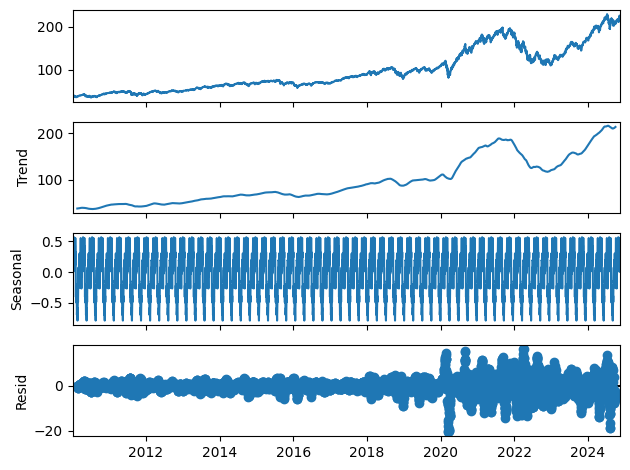

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

#perform seasonal decomposition
result = seasonal_decompose(data, model='additive', period=90)
result.plot()
plt.show()

s = 90

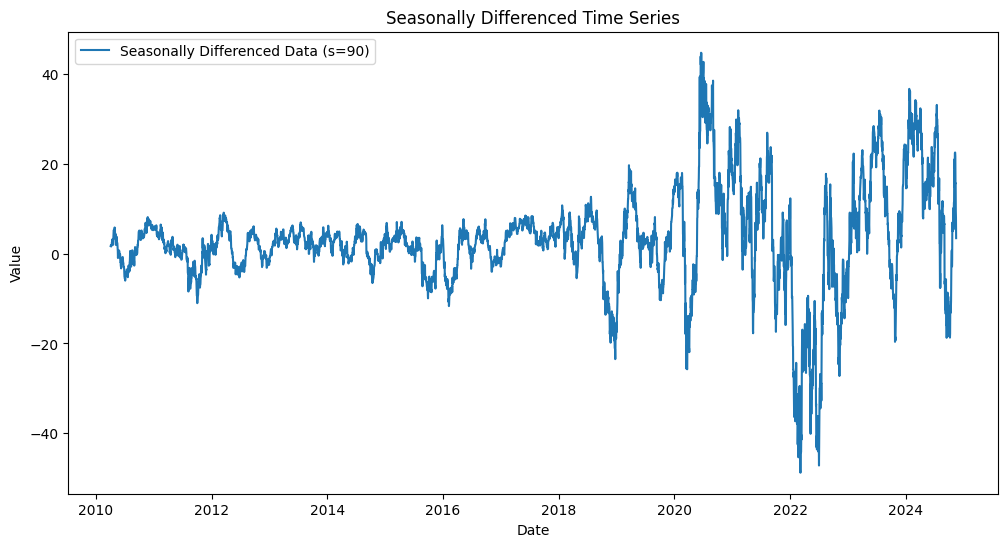

In [9]:
seasonal_diff = data.diff(90).dropna()

#plot seasonal differenced data
plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff, label='Seasonally Differenced Data (s=90)')
plt.title('Seasonally Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [10]:
result = adfuller(seasonal_diff)
print(f'ADF Statistic = {result[0]}, p-value = {result[1]}')

ADF Statistic = -5.776899050366679, p-value = 5.233947679653498e-07


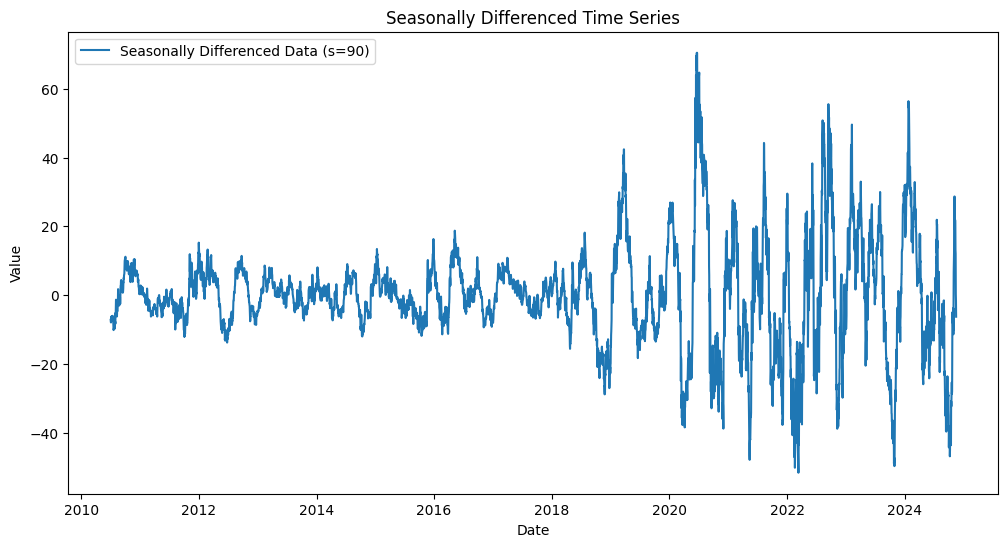

In [11]:
seasonal_diff2 = seasonal_diff.diff(90).dropna()

#plot seasonal differenced data
plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff2, label='Seasonally Differenced Data (s=90)')
plt.title('Seasonally Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

D = 1

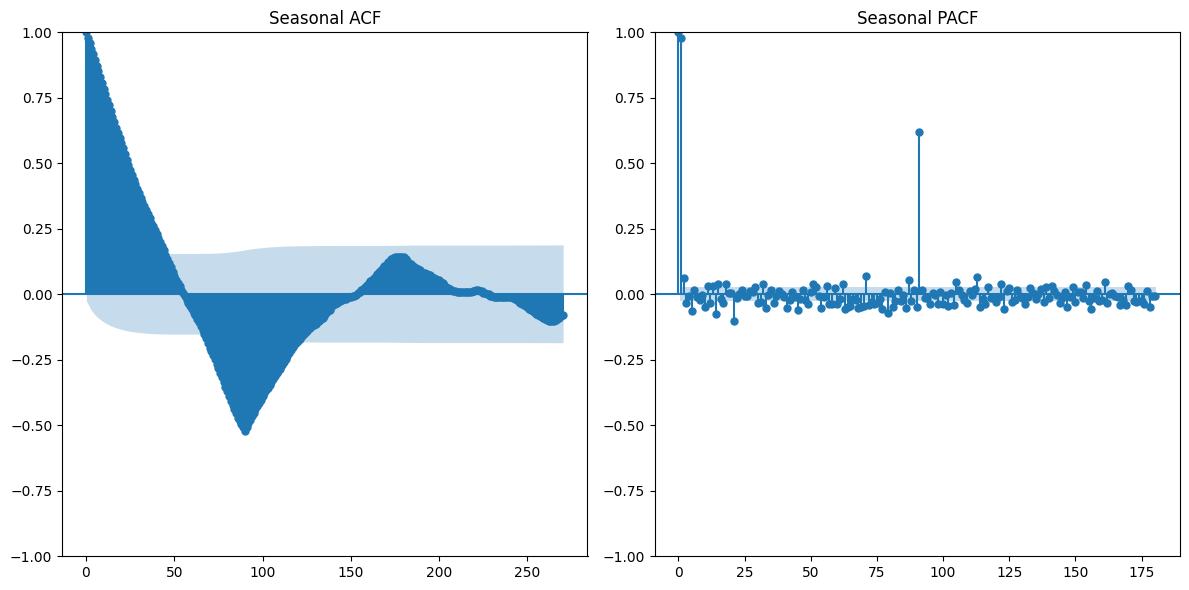

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#plot ACF and PACF for seasonal differenced data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(seasonal_diff2, lags=270, ax=plt.gca())
plt.title('Seasonal ACF')

plt.subplot(1, 2, 2)
plot_pacf(seasonal_diff2, lags=180, ax=plt.gca())
plt.title('Seasonal PACF')

plt.tight_layout()
plt.show()

The partial autocorrelation function plot shows a significant spike at lag 90, which is a multiple of the seasonal period s equal to 90. After this, the values drop off sharply, with no further significant spikes. This indicates that one seasonal autoregressive term is sufficient to capture the remaining seasonal autocorrelation. Therefore, the seasonal autoregressive order P is set to one.

The ACF plot shows a gradual decay in autocorrelations up to lag 90, followed by a similar increase at subsequent multiples of 90, which supports the presence of strong seasonal structure at a 90-day (quarterly) interval. Although the plot lacks sharp, significant spikes at these seasonal lags, the gradual oscillations across these periods still highlight the seasonal nature of the data.

Given this pattern, it suggests that the seasonal behavior can be captured without the need for a seasonal moving average (SMA) component. The absence of pronounced peaks in the ACF implies that the seasonal dynamics are already well-accounted for by the autoregressive (AR) or seasonal autoregressive (SAR) terms. As a result, the seasonal moving average order Q is appropriately set to zero, reflecting the fact that the seasonality is effectively modeled without the need for additional smoothing.

In [13]:
"""
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(
    data,  # Original dataset (not differenced manually; SARIMAX handles this)
    order=(1, 1, 1),  # Non-seasonal ARIMA terms (p, d, q)
    seasonal_order=(1, 2, 0, 90),  # Seasonal terms (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
sarima_result = model.fit(disp=False)

# Print the summary of the model
print(sarima_result.summary())

# Plot diagnostics
sarima_result.plot_diagnostics(figsize=(15, 10))
plt.show()
"""

'\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\nmodel = SARIMAX(\n    data,  # Original dataset (not differenced manually; SARIMAX handles this)\n    order=(1, 1, 1),  # Non-seasonal ARIMA terms (p, d, q)\n    seasonal_order=(1, 2, 0, 90),  # Seasonal terms (P, D, Q, s)\n    enforce_stationarity=False,\n    enforce_invertibility=False\n)\n\n# Fit the model\nsarima_result = model.fit(disp=False)\n\n# Print the summary of the model\nprint(sarima_result.summary())\n\n# Plot diagnostics\nsarima_result.plot_diagnostics(figsize=(15, 10))\nplt.show()\n'

Due to resource limitations, this section of the code is not being executed, as fitting the SARIMA model with these parameters has consistently resulted in insufficient memory (RAM) availability during prior attempts. To ensure efficient use of computational resources, we recommend either optimizing the dataset size, adjusting model parameters, or running this code on a system with greater memory capacity.

# Computing Alpha and Beta with Linear Regression

Linear regression is used to calculate alpha and beta because it models the relationship between the returns of an asset, such as FBGRX, and the returns of a benchmark index, like the Russell 1000. In this context, the slope of the regression line, beta, represents how much the asset's returns move in response to changes in the benchmark's returns, capturing the asset's sensitivity to market movements. The intercept, alpha, measures the asset's performance independent of the benchmark, indicating whether it outperforms or underperforms the market on average. This approach assumes a linear relationship between the asset and the benchmark, which is reasonable for analyzing financial data over short to medium time frames.

The Russell 1000 Index itself is not directly tradable, meaning that you can't invest in the index itself like you can with an ETF. The iShares Russell 1000 ETF (IWB) is designed to track the performance of the Russell 1000 Index, and it's a tradable security. Thus, using IWB allows you to track the performance of the Russell 1000 Index in a way that can be traded, just like a stock or any other ETF.



In [14]:
#define the tickers
fund_ticker = 'FBGRX'
benchmark_ticker = 'IWB'  # iShares Russell 1000 ETF

#define the time period
start_date = '2004-01-01'
end_date = '2024-11-18'

#download the data
fund_data = yf.download(fund_ticker, start=start_date, end=end_date)
benchmark_data = yf.download(benchmark_ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
#calculate daily returns
fund_returns = fund_data['Adj Close'].pct_change().dropna()
benchmark_returns = benchmark_data['Adj Close'].pct_change().dropna()

In [16]:
#combine the returns into a single DataFrame
returns = pd.concat([fund_returns, benchmark_returns], axis=1)
returns.columns = ['Fund', 'Benchmark']

#drop any rows with missing data
returns.dropna(inplace=True)

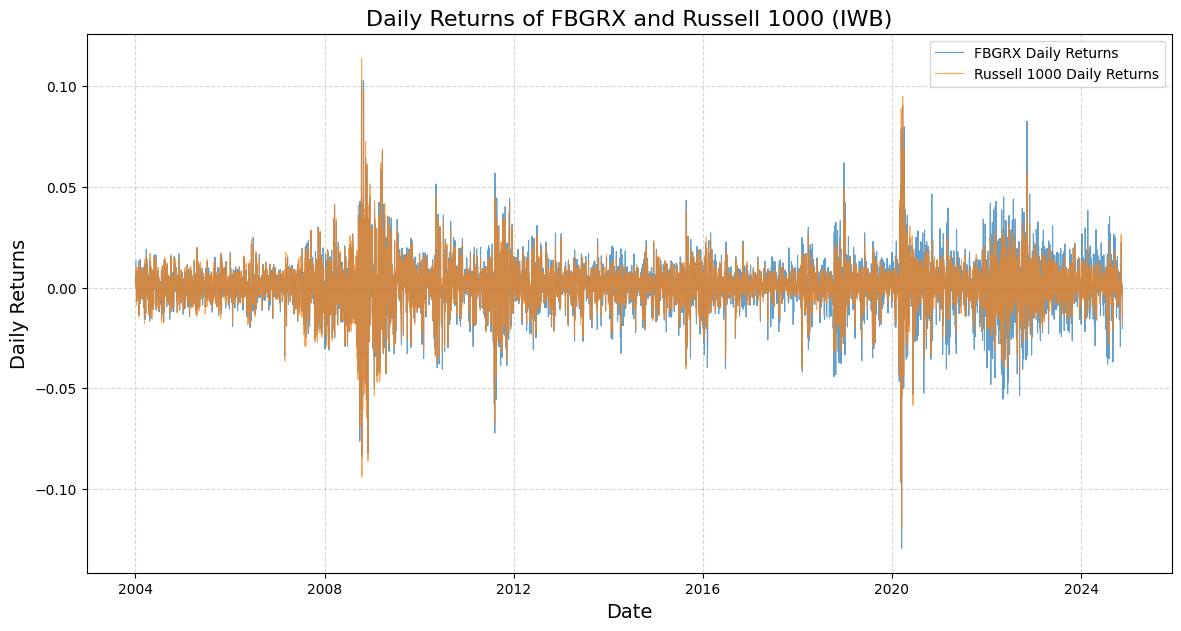

In [17]:
#plot daily returns
plt.figure(figsize=(14, 7))
plt.plot(returns.index, returns['Fund'], label='FBGRX Daily Returns', alpha=0.7, linewidth=0.8)
plt.plot(returns.index, returns['Benchmark'], label='Russell 1000 Daily Returns', alpha=0.7, linewidth=0.8)
plt.title('Daily Returns of FBGRX and Russell 1000 (IWB)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily Returns', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [18]:
import statsmodels.api as sm

In [19]:
#add a constant to the benchmark returns (intercept)
X = sm.add_constant(returns['Benchmark'])
y = returns['Fund']

#perform the regression
model = sm.OLS(y, X).fit()

#extract alpha and beta
alpha = model.params['const']
beta = model.params['Benchmark']

In [20]:
print(f"Alpha: {alpha:.6f}")
print(f"Beta: {beta:.6f}")

Alpha: 0.000078
Beta: 1.086136


The calculated alpha of 0.000078 suggests that the FBGRX fund delivers a very slight positive return independent of market movements, indicating minimal excess returns relative to the benchmark (Russell 1000 ETF). This small value implies that the fund's performance is closely tied to the benchmark, with limited additional gains attributed to fund-specific factors.

The beta of 1.086136 indicates that FBGRX is slightly more volatile than the benchmark. A beta above 1 suggests that the fund's returns tend to amplify market movements—when the benchmark rises or falls, FBGRX is expected to rise or fall by approximately 8.6% more. This level of sensitivity aligns with the fund's growth-oriented strategy, which often invests in higher-risk, higher-reward assets compared to the broader market.

Let's try this with Cholesky decomposition (a method I learned this semester in Statistical Foundations of Data Science and Artificial Intelligence I) for fun!

In [21]:
XtX = np.dot(X.T, X)
Xty = np.dot(X.T, y)

#perform Cholesky decomposition
L = np.linalg.cholesky(XtX)

#solve for z (L * z = X^T * y)
z = np.linalg.solve(L, Xty)

#solve for beta (L.T * beta = z)
beta = np.linalg.solve(L.T, z)

print(f"Alpha: {beta[0]:.6f}")
print(f"Beta: {beta[1]:.6f}")

Alpha: 0.000078
Beta: 1.086136


The results from the Cholesky decomposition were a success as they match the alpha and beta values obtained using the Ordinary Least Squares (OLS) method. This consistency validates the correctness of the Cholesky approach in solving the regression problem and confirms its equivalence to OLS for computing the regression coefficients. It demonstrates that both methods, despite using different computational techniques, produce the same reliable and accurate results for alpha (0.00008) and beta (1.08614).